Материалы Юстины Ивановой: https://github.com/yustinaivanova/netology_statistics_february_20

# Домашняя работа №7.

* Написать модель Random Forest на датасет больных сердечными болезнями (можно почистить от выбросов).

In [1]:
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp
from scipy import stats

In [2]:
url = "http://yustiks.ru/dataset/cardio_train.csv"
data = pd.read_csv(url,sep=";")
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Данный датасет разобран в начале лекции 5. 

Модель Random Forest при обучении дает такой метод как feature importance, используя его, можно оценить, какой параметр **максимально** влияет на болезнь.

* Сделать вывод о том, какой атрибут оказывает значительное влияение на наличие или отсутствие болезни.

Основная задача: определить, что влияет на сердечную болезнь больше всего. Например, выдвигая гипотезу о том, что тот кто курит, болеет чаще, мы сравниваем курящих пациентов с некурящими, и определяя насколько статистически значимы выборки, делаем вывод, что одна выборка статистически отличима от другой (или неотличима).
    Выдвигаем гипотезу на самый важный атрибут, полученный из feature_importance (Random_Forest). И оцениваем гипотезу. И делаем вывод.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [4]:
x, y = data.drop(['id', 'cardio'], axis=1), data.cardio

In [5]:
headers = list(x.columns.values)

In [6]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

np_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(np_scaled)
df_norm.columns = headers
df_norm.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0.588076,1.0,0.579487,0.273684,0.016079,0.013550,0.0,0.0,0.0,0.0,1.0
1,0.730159,0.0,0.517949,0.394737,0.017934,0.014453,1.0,0.0,0.0,0.0,1.0
2,0.624003,0.0,0.564103,0.284211,0.017316,0.012647,1.0,0.0,0.0,0.0,0.0
3,0.528455,1.0,0.584615,0.378947,0.018553,0.015357,0.0,0.0,0.0,0.0,1.0
4,0.516918,0.0,0.517949,0.242105,0.015461,0.011743,0.0,0.0,0.0,0.0,0.0


##### Посмотрим на выбросы

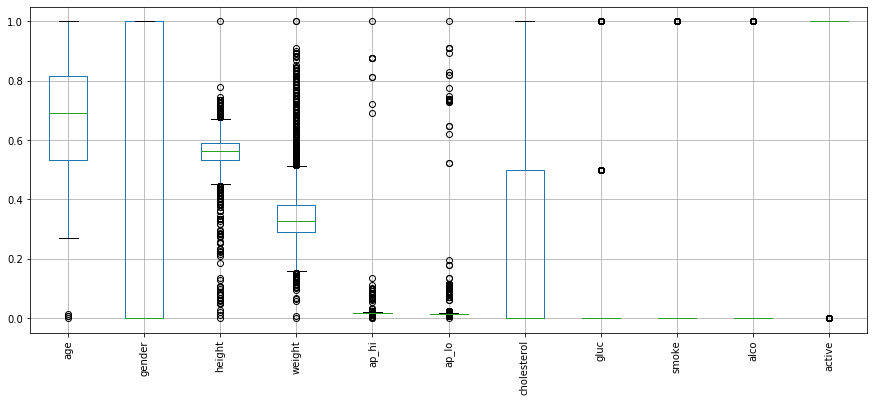

In [7]:
df_norm.boxplot(figsize=(15,6), rot=90)

##### Всем выбросам для атрибутов  'height',  'weight',  'ap_hi' и 'ap_lo' ,  выходящим за квартили 0.05 и 0.95, присвоим значение 0
`

In [8]:
low = 0.05
high = 0.95
quant_df = df_norm.quantile([low, high])

In [9]:
filt_df = df_norm.apply(lambda x: x[(x > quant_df.loc[low, x.name])
                                    & (x < quant_df.loc[high, x.name])]
                        if x.name in ['height', 'weight', 'ap_hi', 'ap_lo']
                        else x, axis=0)

In [10]:
filt_df.fillna(0, inplace=True)

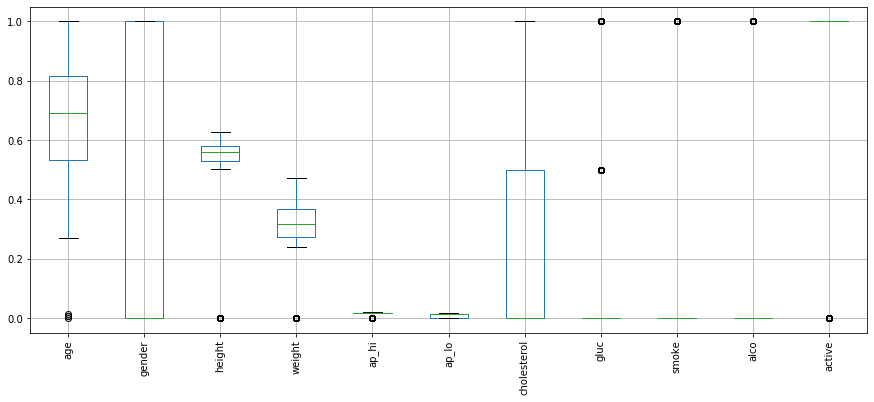

In [11]:
filt_df.boxplot(figsize=(15,6), rot=90)

##### Построим модель Random Forest
`

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(filt_df, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.69      0.70      0.70      6988
           1       0.70      0.69      0.70      7012

    accuracy                           0.70     14000
   macro avg       0.70      0.70      0.70     14000
weighted avg       0.70      0.70      0.70     14000



##### Посмотрим какие атрибуты наиболее важные для модели
`

In [15]:
feature_imp = pd.Series(model.feature_importances_, index=headers).sort_values(ascending=False)
feature_imp

age            0.353490
weight         0.170522
height         0.155336
ap_hi          0.146425
ap_lo          0.062632
cholesterol    0.042184
gender         0.019012
gluc           0.018297
active         0.013937
smoke          0.009646
alco           0.008520
dtype: float64

Text(0, 0.5, 'Features')

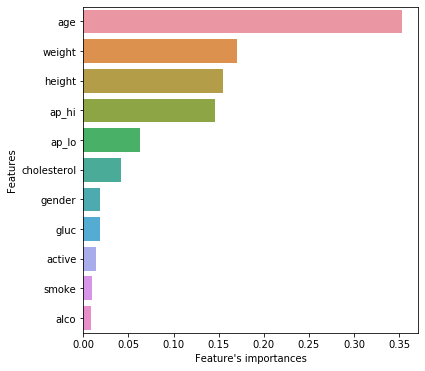

In [16]:
f, ax = plt.subplots(figsize=(6,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature\'s importances')
plt.ylabel('Features')

##### Сравним с важностью атрибутов с учётом выбросов

In [17]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df_norm, y, test_size=0.2, random_state=42)
model2 = RandomForestClassifier(n_estimators=100)
model2.fit(X2_train, y2_train)
feature_imp2 = pd.Series(model2.feature_importances_, index=headers).sort_values(ascending=False)
feature_imp2

age            0.308405
weight         0.172704
ap_hi          0.171891
height         0.157022
ap_lo          0.091771
cholesterol    0.037897
gluc           0.016510
gender         0.015222
active         0.012933
smoke          0.008401
alco           0.007244
dtype: float64

##### С учётом выбросов систолическое давление приблизилось ко второму по важности значению.
`

##### Используя метод feature_importances_ делаем вывод, что для нашей модели Random Forest в деле предсказания болезни важнее 
##### всего возраст. Вес, систолическое давление и рост менее важны, ещё меньше диастолическое давление. А курение и 
##### употребление алкоголя имеют наименьшую важность для предсказания болезни нашей моделью и их важность по сравнению с 
##### наиболее важными признаками незначительна.
`

##### Проверим статистическую значимость наиболее важного атрибута - возраст, значения систолического давления
##### и наименее важного - употребление алкоголя.
`

---
##### Проверим гипотезу о том, что сердечно-сосудистые заболевания (ССЗ) людей зависят от их возраста.
 Гипотеза H0 - средние значения людей с заболеваниями до 54 лет и после 54 лет равны (т.е. не зависит от возраста)
 
 Гипотеза H1 - средние значения не равны (заболевания зависят от возраста)

In [18]:
# Найдём моду показаний возраста
data.age.mode()

0    18236
1    19741
dtype: int64

In [19]:
# Переведём в года
19741 / 365

54.084931506849315

In [20]:
age_less = data[data['age'] <= 19741].cardio
age_more = data[data['age'] > 19741].cardio
descriptives, results = rp.ttest(age_less, age_more)
print(descriptives)
print('______________________________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  35780.0  0.405618  0.491018  0.002596   0.400530  0.410706
1    cardio  34220.0  0.598071  0.490295  0.002650   0.592876  0.603266
2  combined  70000.0  0.499700  0.500003  0.001890   0.495996  0.503404
______________________________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.1925
1            Degrees of freedom =   69998.0000
2                             t =     -51.8743
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.3922
7                     Hedge's g =      -0.3922
8                 Glass's delta =      -0.3919
9                             r =       0.1924


Т.к. p value = 0.0000, т. е. вероятность ошибки первого рода равна 0, то мы отвергаем нулевую гипотезу. 
Из того, что среднее значение = 0.405 людей с заболеваниями возраста до 54 лет меньше среднего значения = 0.598 людей после 54 лет, делаем вывод, что 
##### с возрастом люди чаще подвержены сердечно-сосудистым заболеваниям
---

---
##### Выдвинем гипотезу о том, что у людей с высоким систолическим давлением чаще встречаются ССЗ.

In [21]:
data.ap_hi.mode()

0    120
dtype: int64

In [22]:
ap_hi_less = data[data['ap_hi'] <= 120].cardio
ap_hi_more = data[data['ap_hi'] > 120].cardio
descriptives, results = rp.ttest(ap_hi_less, ap_hi_more)
print(descriptives)
print('______________________________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  40737.0  0.317893  0.465663  0.002307   0.313371  0.322415
1    cardio  29263.0  0.752794  0.431395  0.002522   0.747851  0.757737
2  combined  70000.0  0.499700  0.500003  0.001890   0.495996  0.503404
______________________________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.4349
1            Degrees of freedom =   69998.0000
2                             t =    -125.6577
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.9629
7                     Hedge's g =      -0.9629
8                 Glass's delta =      -0.9339
9                             r =       0.4290


##### Видим, что p value = 0.0000 и среднее значение больше у людей с ССЗ с систолическим давлением большим 120. 
##### Значит эта гипотеза статистически значима.
---

---
##### Выдвинем гипотезу о том, что людей, употребляющих алкоголь, среди имеющих ССЗ больше, чем тех, кто не употребляет.

In [23]:
alcohol = data[data.alco == 1].cardio
no_alcohol = data[data.alco == 0].cardio
descriptives, results = rp.ttest(alcohol, no_alcohol)
print(descriptives)
print('______________________________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio   3764.0  0.484325  0.499821  0.008147   0.468353  0.500298
1    cardio  66236.0  0.500574  0.500003  0.001943   0.496766  0.504382
2  combined  70000.0  0.499700  0.500003  0.001890   0.495996  0.503404
______________________________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.0162
1            Degrees of freedom =   69998.0000
2                             t =      -1.9394
3         Two side test p value =       0.0525
4        Difference < 0 p value =       0.0262
5        Difference > 0 p value =       0.9738
6                     Cohen's d =      -0.0325
7                     Hedge's g =      -0.0325
8                 Glass's delta =      -0.0325
9                             r =       0.0073


##### p value = 0.0525 больше уровня значимости 0.05, хотя и близкое к нему. Исходя из этого мы не можем сказать, что выдвинутая 
##### нами гипотеза статистически значима. Возможно, это связано со значительно меньшим количеством, употребляющих 
##### алкоголь, людей в выборке.